## Homework 01. Simple text processing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from IPython import display

### Toxic or not
Your main goal in this assignment is to classify, whether the comments are toxic or not. And practice with both classical approaches and PyTorch in the process.

*Credits: This homework is inspired by YSDA NLP_course.*

In [2]:
# In colab uncomment this cell
# ! wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/homeworks/homework01/utils.py -nc

In [3]:
try:
    data = pd.read_csv('../../made_nlp_course/datasets/comments_small_dataset/comments.tsv', sep='\t')
except FileNotFoundError:
    ! wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/comments_small_dataset/comments.tsv -nc
    data = pd.read_csv("comments.tsv", sep='\t')

In [4]:
texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

should_ban                                       comment_text
50            0  "Those who're in advantageous positions are th...
250           1          Fartsalot56 says f**k you motherclucker!!
450           1  Are you a fool? \n\nI am sorry, but you seem t...
650           1    I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850           0  Citing sources\n\nCheck out the Wikipedia:Citi...

In [5]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

Generally, library `nltk` [link](https://www.nltk.org) is widely used in NLP. It is not necessary in here, but mentioned to intoduce it to you.

In [6]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown-up at work : replace " i don't want to do that " with " ok , great ! " .


In [7]:
# task: preprocess each comment in train and test

texts_train = [preprocess(el) for el in texts_train] #<YOUR CODE>
texts_test = [preprocess(el) for el in texts_test]#<YOUR CODE>

In [8]:
# Small check that everything is done properly
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Step 1: bag of words

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. __Please don't do that in the current assignment, though.__
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [9]:
from collections import Counter

# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
k = min(10000, len(set(' '.join(texts_train).split())))

cv = Counter(' '.join(texts_train).split())#<YOUR CODE>

bow_vocabulary = [el[0] for el in sorted(cv.items(), key=lambda x:x[1], reverse=True)[:k]]#<YOUR CODE>
bow_vocabulary.append('<unknown>')

print('example features:', sorted(bow_vocabulary)[::100])

example features: ['!', '12:20', '300', '^', 'adopted', 'alternate', 'archimedes', 'available', 'benidorm', 'bound', 'cambridge', 'cherokee', 'combination', 'consumer', 'creeping', 'decision', 'dick', 'dollar', 'educational', 'essence', 'fagget', 'fired', 'front', 'goaded', 'hands', 'hinders', 'identical', 'infobox', 'israelis', 'kind', "let's", 'lost', 'mckenna', 'moderation', 'nationality', 'notice', 'opposed', 'pc', 'planet', 'pretend', 'punchline', 'reasons', 'repeating', 'rhetorical', 'schools', 'sheeple', 'slim', 'spoken', 'stunning', 'syte', 'then', 'top', 'ugly', 'users', 'want', "wiki's", 'yeah', 'ி']


In [10]:
def text_to_bow(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    res = np.zeros(len(bow_vocabulary))
    cv = Counter(text.split())
    for w, amm in cv.items():
        if w in bow_vocabulary:
            res[bow_vocabulary.index(w)] = amm
        else:
            res[len(bow_vocabulary) - 1] += amm

    return np.array(res, 'float32')


In [11]:
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

In [12]:
# Small check that everything is done properly
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max) + 1)
assert X_test_bow.shape == (len(texts_test), min(k, k_max) + 1)
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max) + 1
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

Now let's do the trick with `sklearn` logistic regression implementation:

In [13]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression().fit(X_train_bow, y_train)

In [18]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Seems alright. Now let's create the simple logistic regression using PyTorch. Just like in the classwork.

In [15]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

from sklearn.metrics import accuracy_score

In [16]:
from utils import plot_train_process

In [17]:
inp_shape = X_train_bow.shape[1]

In [18]:
model = nn.Sequential()

model.add_module('l1', nn.Linear(inp_shape, 1000))### YOUR CODE HERE
model.add_module('a1', nn.LeakyReLU(1000))
model.add_module('l3', nn.Linear(1000, 2))

Remember what we discussed about loss functions! `nn.CrossEntropyLoss` combines both log-softmax and `NLLLoss`.

__Be careful with it! Criterion `nn.CrossEntropyLoss` with still work with log-softmax output, but it won't allow you to converge to the optimum.__ Next comes small demonstration:

In [19]:
# loss_function = nn.NLLLoss()
loss_function = nn.CrossEntropyLoss()

In [20]:
opt = torch.optim.AdamW(model.parameters(), lr=3e-3)### YOUR CODE HERE
lr_scheduler = ReduceLROnPlateau(opt, patience=5)

In [21]:
X_train_bow_torch = torch.tensor(X_train_bow) ### YOUR CODE HERE
X_test_bow_torch = torch.tensor(X_test_bow) ### YOUR CODE HERE

y_train_torch = torch.tensor(y_train) ### YOUR CODE HERE
y_test_torch = torch.tensor(y_test) ### YOUR CODE HERE

Let's test that everything is fine

In [22]:
# example loss
loss = loss_function(model(X_train_bow_torch[:3]), y_train_torch[:3])

In [23]:
assert type(loss.item()) == float

Here comes small function to train the model. In future we will take in into separate file, but for this homework it's ok to implement it here. 

In [115]:
def train_model(
    model,
    opt,
    lr_scheduler,
    X_train_torch,
    y_train_torch,
    X_val_torch,
    y_val_torch,
    n_iterations=500,
    batch_size=32,
    warm_start=False,
    show_plots=True,
    eval_every=10
):
    if not warm_start:
        for name, module in model.named_children():
            print('resetting ', name)
            try:
                module.reset_parameters()
            except AttributeError as e:
                print('Cannot reset {} module parameters: {}'.format(name, e))

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []
    for i in range(n_iterations):

        # sample 256 random observations
        ix = np.random.randint(0, len(X_train_torch), batch_size)
        x_batch = X_train_torch[ix]
        y_batch = y_train_torch[ix]

        # predict log-probabilities or logits
        y_predicted = model(x_batch) ### YOUR CODE

        # compute loss, just like before
        ### YOUR CODE
        loss = loss_function(y_predicted, y_batch)

        # compute gradients
        ### YOUR CODE
        loss.backward()

        # Adam step
        ### YOUR CODE
        opt.step()

        # clear gradients
        ### YOUR CODE
        opt.zero_grad()

        local_train_loss_history.append(loss.data.numpy())
        local_train_acc_history.append(
            accuracy_score(
                y_batch.to('cpu').detach().numpy(),
                y_predicted.to('cpu').detach().numpy().argmax(axis=1)
            )
        )

        if i % eval_every == 0:
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []

            predictions_val = model(X_val_torch)
            val_loss_history.append(loss_function(predictions_val, y_val_torch).to('cpu').detach().item())

            acc_score_val = accuracy_score(y_val_torch.cpu().numpy(), predictions_val.to('cpu').detach().numpy().argmax(axis=1))
            val_acc_history.append(acc_score_val)
            lr_scheduler.step(train_loss_history[-1])

            if show_plots:
                display.clear_output(wait=True)
                plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
    return model

Let's run it on the data. Note, that here we use the `test` part of the data for validation. It's not so good idea in general, but in this task our main goal is practice.

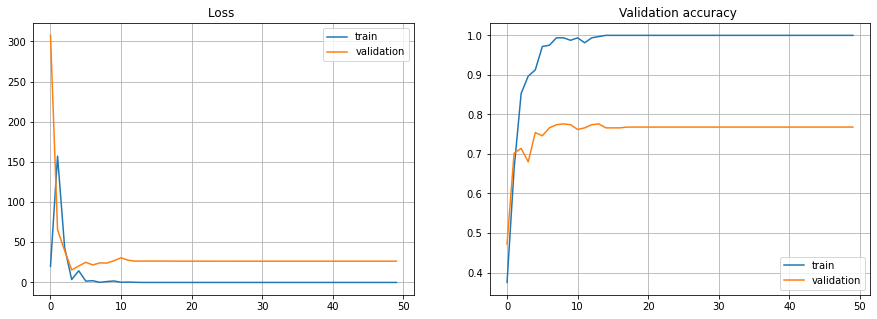

Sequential(
  (l1): Linear(in_features=5723, out_features=1000, bias=True)
  (a1): LeakyReLU(negative_slope=1000)
  (l3): Linear(in_features=1000, out_features=2, bias=True)
)

In [25]:
train_model(model, opt, lr_scheduler, X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch)

In [26]:
roc_auc_score(y_test, model(X_test_bow_torch).detach().cpu().numpy()[:, 1])

0.842900593829962

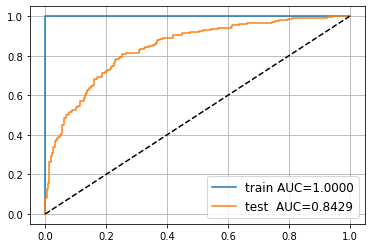

In [27]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow_torch, y_train, model),
    ('test ', X_test_bow_torch, y_test, model)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Try to vary the number of tokens `k` and check how the model performance changes. Show it on a plot.

In [28]:
k_arr = range(100, 2000, 200)
aucs_train = []
aucs_test = []

for max_k in k_arr:
    k = min(max_k, len(set(' '.join(texts_train).split())))

    cv = Counter(' '.join(texts_train).split())#<YOUR CODE>

    bow_vocabulary = [el[0] for el in sorted(cv.items(), key=lambda x:x[1], reverse=True)[:k]]#<YOUR CODE>
    bow_vocabulary.append('<unknown>')

    X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
    X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

    inp_shape = X_train_bow.shape[1]
    model = nn.Sequential()
    model.add_module('l1', nn.Linear(inp_shape, inp_shape))### YOUR CODE HERE
    model.add_module('a1', nn.LeakyReLU(inp_shape))
    model.add_module('l2', nn.Linear(inp_shape, 2))

    lr_scheduler = ReduceLROnPlateau(opt, patience=5)
    loss_function = nn.CrossEntropyLoss()
    opt = torch.optim.AdamW(model.parameters(), lr=3e-3)### YOUR CODE HERE
    
    X_train_bow_torch = torch.tensor(X_train_bow) ### YOUR CODE HERE
    X_test_bow_torch = torch.tensor(X_test_bow) ### YOUR CODE HERE
    y_train_torch = torch.tensor(y_train) ### YOUR CODE HERE
    y_test_torch = torch.tensor(y_test) ### YOUR CODE HERE
    
    train_model(model, opt, lr_scheduler, X_train_bow_torch, y_train_torch,
                X_test_bow_torch, y_test_torch, show_plots=False)

    proba = model(X_test_bow_torch).detach().cpu().numpy()[:, 1]
    aucs_train.append(roc_auc_score(y_train, model(X_train_bow_torch).detach().cpu().numpy()[:, 1]))
    aucs_test.append(roc_auc_score(y_test, proba))

resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l2
resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l2
resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l2
resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l2
resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l2
resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l2
resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l2
resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' o

I was varying k in [100, 1500]. Model: k --> k --> leakyReLU --> 2

TEST: best vocabulary size: 900, max auc: 0.8492894961296449


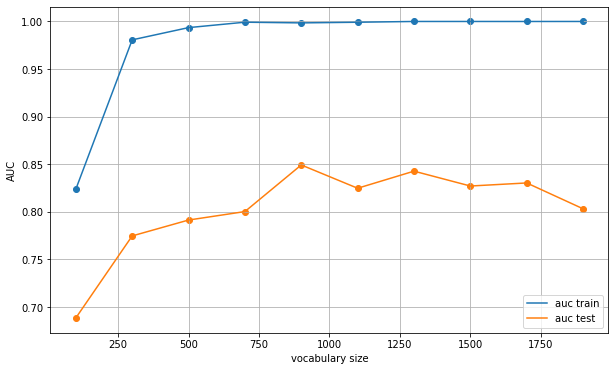

In [29]:
print('TEST: best vocabulary size: {}, max auc: {}'.format(k_arr[np.argmax(aucs_test)],
                                             np.max(aucs_test)))

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(k_arr, aucs_train, label='auc train')
plt.scatter(k_arr, aucs_train)
plt.plot(k_arr, aucs_test, label='auc test')
plt.scatter(k_arr, aucs_test)
plt.xlabel('vocabulary size')
plt.ylabel('AUC')
plt.legend()
plt.show()

### Step 2: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }}, $$


where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

__Please don't use sklearn/nltk builtin tf-idf vectorizers in your solution :)__ You can still use 'em for debugging though.

Blog post about implementing the TF-IDF features from scratch: https://triton.ml/blog/tf-idf-from-scratch

In [30]:
def count_tf(texts, vocab):
    arr = np.zeros((len(texts), len(vocab)))
    texts = [el.split() for el in texts]
    for text_idx in range(len(texts)):
        for w in texts[text_idx]:
            if w in bow_vocabulary:
                arr[text_idx, bow_vocabulary.index(w)] += 1
            else:
                arr[text_idx, -1] += 1
                
    return arr / arr.sum(axis=1).reshape(-1, 1)

def count_df(texts, vocab):
    arr = np.zeros((len(texts), len(vocab)))
    texts = [el.split() for el in texts]
    for text_idx in range(len(texts)):
        for w in texts[text_idx]:
            if w in bow_vocabulary:
                arr[text_idx, bow_vocabulary.index(w)] = 1
            else:
                arr[text_idx, -1] = 1
                
    return arr.sum(axis=0).reshape(-1, 1)

def count_tfidf(texts, vocab):
    tf = count_tf(texts_train, vocab)
    df = count_df(texts_train, vocab).reshape(-1)
    idf = np.log(len(texts) / (df + 1))

    tfidf = tf * idf
    tfidf_normed = tfidf / np.sqrt((tfidf ** 2).sum(axis=1)).reshape(-1, 1)

class tfidf_vectorizer():
    def __init__(self, vocab):
        self.vocab = vocab
        
    def fit(self, texts):
        df = count_df(texts_train, self.vocab).reshape(-1)
        self.idf = np.log(len(texts) / (df + 1))
        
    def transform(self, texts):
        tf = count_tf(texts, self.vocab)
        tfidf = tf * self.idf
        tfidf_normed = tfidf / np.sqrt((tfidf ** 2).sum(axis=1)).reshape(-1, 1)
        return tfidf_normed

Same stuff about moel and optimizers here (or just omit it, if you are using the same model as before).

In [116]:
max_k = 10000
k = min(max_k, len(set(' '.join(texts_train).split())))

cv = Counter(' '.join(texts_train).split())#<YOUR CODE>

bow_vocabulary = [el[0] for el in sorted(cv.items(), key=lambda x:x[1], reverse=True)[:k]]#<YOUR CODE>
bow_vocabulary.append('<unknown>')

In [117]:
vect = tfidf_vectorizer(bow_vocabulary)
vect.fit(texts_train)

X_train_tfidf = vect.transform(texts_train)
X_test_tfidf = vect.transform(texts_test)

In [118]:
X_train_tfidf_torch = torch.tensor(X_train_tfidf).float()
X_test_tfidf_torch = torch.tensor(X_test_tfidf).float()

y_train_torch = torch.tensor(y_train)
y_test_torch = torch.tensor(y_test)

In [119]:
inp_shape = X_train_tfidf.shape[1]

In [120]:
model = nn.Sequential()

model.add_module('l1', nn.Linear(inp_shape, 1000))### YOUR CODE HERE
model.add_module('a1', nn.LeakyReLU(1000))
model.add_module('l2', nn.Linear(1000, 2))

In [121]:
loss_function = nn.CrossEntropyLoss()

In [122]:
opt = torch.optim.AdamW(model.parameters(), lr=3e-4)### YOUR CODE HERE
lr_scheduler = ReduceLROnPlateau(opt, patience=5)

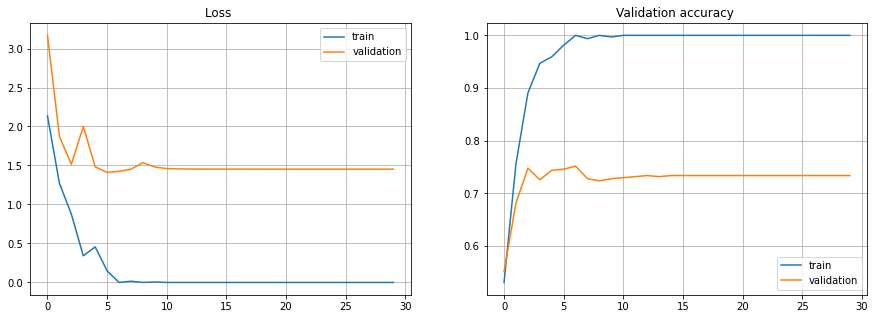

Sequential(
  (l1): Linear(in_features=5723, out_features=1000, bias=True)
  (a1): LeakyReLU(negative_slope=1000)
  (l2): Linear(in_features=1000, out_features=2, bias=True)
)

In [123]:
train_model(model, opt, lr_scheduler, X_train_tfidf_torch, y_train_torch,
            X_test_tfidf_torch, y_test_torch, n_iterations=300)

Fit your model to the data. No not hesitate to vary number of iterations, learning rate and so on.

_Note: due to very small dataset, increasing the complexity of the network might not be the best idea._

##### change k

In [40]:
k_arr = range(300, 1500, 150)
aucs_train = []
aucs_test = []

for max_k in k_arr:
    k = min(max_k, len(set(' '.join(texts_train).split())))

    cv = Counter(' '.join(texts_train).split())#<YOUR CODE>

    bow_vocabulary = [el[0] for el in sorted(cv.items(), key=lambda x:x[1], reverse=True)[:k]]#<YOUR CODE>
    bow_vocabulary.append('<unknown>')

    vect = tfidf_vectorizer(bow_vocabulary)
    vect.fit(texts_train)

    X_train_tfidf = vect.transform(texts_train)
    X_test_tfidf = vect.transform(texts_test)

    inp_shape = X_train_tfidf.shape[1]
    model = nn.Sequential()
    model.add_module('l1', nn.Linear(inp_shape, inp_shape))### YOUR CODE HERE
    model.add_module('a1', nn.LeakyReLU(inp_shape))
    model.add_module('l3', nn.Linear(inp_shape, 2))

    lr_scheduler = ReduceLROnPlateau(opt, patience=5)
    loss_function = nn.CrossEntropyLoss()
    opt = torch.optim.AdamW(model.parameters(), lr=3e-3)### YOUR CODE HERE
    
    X_train_tfidf_torch = torch.tensor(X_train_tfidf).float() ### YOUR CODE HERE
    X_test_tfidf_torch = torch.tensor(X_test_tfidf).float() ### YOUR CODE HERE
    y_train_torch = torch.tensor(y_train) ### YOUR CODE HERE
    y_test_torch = torch.tensor(y_test) ### YOUR CODE HERE
    
    train_model(model, opt, lr_scheduler, X_train_tfidf_torch, y_train_torch,
                X_test_tfidf_torch, y_test_torch, show_plots=False)

    proba = model(X_test_tfidf_torch).detach().cpu().numpy()[:, 1]
    aucs_train.append(roc_auc_score(y_train, model(X_train_tfidf_torch).detach().cpu().numpy()[:, 1]))
    aucs_test.append(roc_auc_score(y_test, proba))

resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l3
resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l3
resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l3
resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l3
resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l3
resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l3
resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l3
resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' o

TEST: best vocabulary size: 900, max auc: 0.8366082492476543


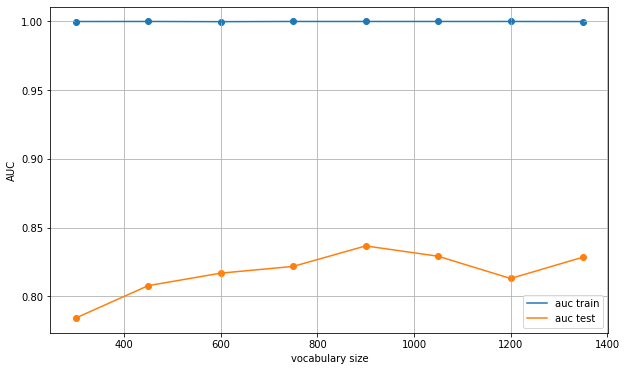

In [41]:
print('TEST: best vocabulary size: {}, max auc: {}'.format(k_arr[np.argmax(aucs_test)],
                                             np.max(aucs_test)))

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(k_arr, aucs_train, label='auc train')
plt.scatter(k_arr, aucs_train)
plt.plot(k_arr, aucs_test, label='auc test')
plt.scatter(k_arr, aucs_test)
plt.xlabel('vocabulary size')
plt.ylabel('AUC')
plt.legend()
plt.show()

##### change lr

In [42]:
max_k = 800
lr_lins = np.linspace(1e-2, 1e-5, 10)
aucs_train = []
aucs_test = []

k = min(max_k, len(set(' '.join(texts_train).split())))

cv = Counter(' '.join(texts_train).split())#<YOUR CODE>

bow_vocabulary = [el[0] for el in sorted(cv.items(), key=lambda x:x[1], reverse=True)[:k]]#<YOUR CODE>
bow_vocabulary.append('<unknown>')

vect = tfidf_vectorizer(bow_vocabulary)
vect.fit(texts_train)

X_train_tfidf = vect.transform(texts_train)
X_test_tfidf = vect.transform(texts_test)

for lr in lr_lins:
    inp_shape = X_train_tfidf.shape[1]
    model = nn.Sequential()
    model.add_module('l1', nn.Linear(inp_shape, inp_shape))### YOUR CODE HERE
    model.add_module('a1', nn.LeakyReLU(inp_shape))
    model.add_module('l2', nn.Linear(inp_shape, 2))

    lr_scheduler = ReduceLROnPlateau(opt, patience=5)
    loss_function = nn.CrossEntropyLoss()
    opt = torch.optim.AdamW(model.parameters(), lr=lr)### YOUR CODE HERE
    
    X_train_tfidf_torch = torch.tensor(X_train_tfidf).float() ### YOUR CODE HERE
    X_test_tfidf_torch = torch.tensor(X_test_tfidf).float() ### YOUR CODE HERE
    y_train_torch = torch.tensor(y_train) ### YOUR CODE HERE
    y_test_torch = torch.tensor(y_test) ### YOUR CODE HERE
    
    train_model(model, opt, lr_scheduler, X_train_tfidf_torch, y_train_torch,
                X_test_tfidf_torch, y_test_torch, show_plots=False)

    proba = model(X_test_tfidf_torch).detach().cpu().numpy()[:, 1]
    aucs_train.append(roc_auc_score(y_train, model(X_train_tfidf_torch).detach().cpu().numpy()[:, 1]))
    aucs_test.append(roc_auc_score(y_test, proba))

resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l2
resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l2
resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l2
resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l2
resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l2
resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l2
resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l2
resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' o

TEST: best learning rate: 0.00667, max auc: 0.8691482000032186


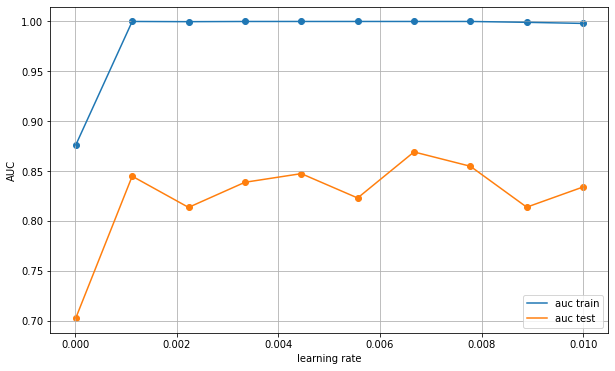

In [43]:
print('TEST: best learning rate: {}, max auc: {}'.format(lr_lins[np.argmax(aucs_test)],
                                             np.max(aucs_test)))

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(lr_lins, aucs_train, label='auc train')
plt.scatter(lr_lins, aucs_train)
plt.plot(lr_lins, aucs_test, label='auc test')
plt.scatter(lr_lins, aucs_test)
plt.xlabel('learning rate')
plt.ylabel('AUC')
plt.legend()
plt.show()

##### changing epochs ammount

In [44]:
max_k = 800
n_iter_lins = np.arange(200, 500, 25)
aucs_train = []
aucs_test = []

k = min(max_k, len(set(' '.join(texts_train).split())))

cv = Counter(' '.join(texts_train).split())#<YOUR CODE>

bow_vocabulary = [el[0] for el in sorted(cv.items(), key=lambda x:x[1], reverse=True)[:k]]#<YOUR CODE>
bow_vocabulary.append('<unknown>')

vect = tfidf_vectorizer(bow_vocabulary)
vect.fit(texts_train)

X_train_tfidf = vect.transform(texts_train)
X_test_tfidf = vect.transform(texts_test)

for n_iter in n_iter_lins:
    inp_shape = X_train_tfidf.shape[1]
    model = nn.Sequential()
    model.add_module('l1', nn.Linear(inp_shape, inp_shape))### YOUR CODE HERE
    model.add_module('a1', nn.LeakyReLU(inp_shape))
    model.add_module('l2', nn.Linear(inp_shape, 2))

    lr_scheduler = ReduceLROnPlateau(opt, patience=5)
    loss_function = nn.CrossEntropyLoss()
    opt = torch.optim.AdamW(model.parameters(), lr=0.00556)### YOUR CODE HERE
    
    X_train_tfidf_torch = torch.tensor(X_train_tfidf).float() ### YOUR CODE HERE
    X_test_tfidf_torch = torch.tensor(X_test_tfidf).float() ### YOUR CODE HERE
    y_train_torch = torch.tensor(y_train) ### YOUR CODE HERE
    y_test_torch = torch.tensor(y_test) ### YOUR CODE HERE
    
    train_model(model, opt, lr_scheduler, X_train_tfidf_torch, y_train_torch,
                X_test_tfidf_torch, y_test_torch, show_plots=False, n_iterations=n_iter)

    proba = model(X_test_tfidf_torch).detach().cpu().numpy()[:, 1]
    aucs_train.append(roc_auc_score(y_train, model(X_train_tfidf_torch).detach().cpu().numpy()[:, 1]))
    aucs_test.append(roc_auc_score(y_test, proba))

resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l2
resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l2
resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l2
resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l2
resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l2
resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l2
resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l2
resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' o

TEST: best n_iter: 450, max auc: 0.8544714269621333


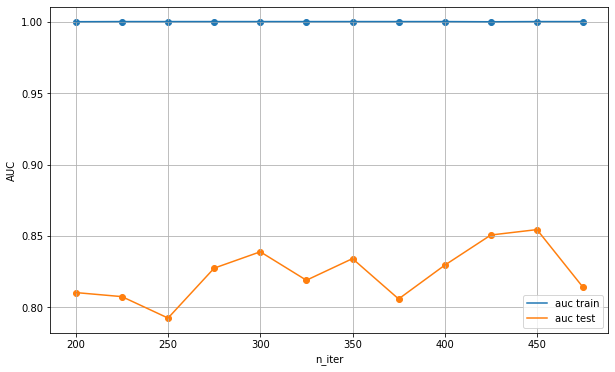

In [45]:
print('TEST: best n_iter: {}, max auc: {}'.format(n_iter_lins[np.argmax(aucs_test)],
                                             np.max(aucs_test)))

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(n_iter_lins, aucs_train, label='auc train')
plt.scatter(n_iter_lins, aucs_train)
plt.plot(n_iter_lins, aucs_test, label='auc test')
plt.scatter(n_iter_lins, aucs_test)
plt.xlabel('n_iter')
plt.ylabel('AUC')
plt.legend()
plt.show()

##### trying make model more complex

In [46]:
k_arr = range(300, 2500, 250)
aucs_train = []
aucs_test = []

for max_k in k_arr:
    k = min(max_k, len(set(' '.join(texts_train).split())))

    cv = Counter(' '.join(texts_train).split())#<YOUR CODE>

    bow_vocabulary = [el[0] for el in sorted(cv.items(), key=lambda x:x[1], reverse=True)[:k]]#<YOUR CODE>
    bow_vocabulary.append('<unknown>')

    vect = tfidf_vectorizer(bow_vocabulary)
    vect.fit(texts_train)

    X_train_tfidf = vect.transform(texts_train)
    X_test_tfidf = vect.transform(texts_test)

    inp_shape = X_train_tfidf.shape[1]
    model = nn.Sequential()
    model.add_module('l1', nn.Linear(inp_shape, inp_shape))### YOUR CODE HERE
    model.add_module('a1', nn.LeakyReLU(inp_shape))
    model.add_module('l2', nn.Linear(inp_shape, int(inp_shape / 2)))
    model.add_module('a2', nn.LeakyReLU(int(inp_shape / 2)))
    model.add_module('l3', nn.Linear(int(inp_shape / 2), 2))

    lr_scheduler = ReduceLROnPlateau(opt, patience=5)
    loss_function = nn.CrossEntropyLoss()
    opt = torch.optim.AdamW(model.parameters(), lr=3e-3)### YOUR CODE HERE
    
    X_train_tfidf_torch = torch.tensor(X_train_tfidf).float() ### YOUR CODE HERE
    X_test_tfidf_torch = torch.tensor(X_test_tfidf).float() ### YOUR CODE HERE
    y_train_torch = torch.tensor(y_train) ### YOUR CODE HERE
    y_test_torch = torch.tensor(y_test) ### YOUR CODE HERE
    
    train_model(model, opt, lr_scheduler, X_train_tfidf_torch, y_train_torch,
                X_test_tfidf_torch, y_test_torch, show_plots=False)

    proba = model(X_test_tfidf_torch).detach().cpu().numpy()[:, 1]
    aucs_train.append(roc_auc_score(y_train, model(X_train_tfidf_torch).detach().cpu().numpy()[:, 1]))
    aucs_test.append(roc_auc_score(y_test, proba))

resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l2
resetting  a2
Cannot reset a2 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l3
resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l2
resetting  a2
Cannot reset a2 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l3
resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l2
resetting  a2
Cannot reset a2 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l3
resetting  l1
resetting  a1
Cannot reset a1 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l2
resetting  a2
Cannot reset a2 module parameters: 'LeakyReLU' object has no attribute 'reset_parameters'
resetting  l3


TEST: best vocabulary size: 2050, max auc: 0.847052575677111


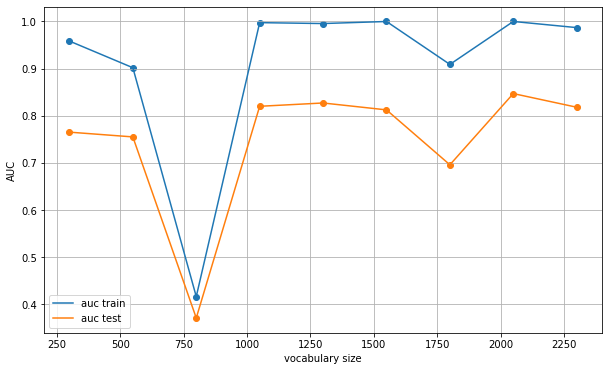

In [47]:
print('TEST: best vocabulary size: {}, max auc: {}'.format(k_arr[np.argmax(aucs_test)],
                                             np.max(aucs_test)))

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(k_arr, aucs_train, label='auc train')
plt.scatter(k_arr, aucs_train)
plt.plot(k_arr, aucs_test, label='auc test')
plt.scatter(k_arr, aucs_test)
plt.xlabel('vocabulary size')
plt.ylabel('AUC')
plt.legend()
plt.show()

### Step 3: Comparing it with Naive Bayes

Naive Bayes classifier is a good choice for such small problems. Try to tune it for both BOW and TF-iDF features. Compare the results with Logistic Regression.

In [48]:
from sklearn.naive_bayes import GaussianNB

lins = np.linspace(1e-02, 1e-07, 100)
aucs_train_gb = []
aucs_test_gb = []

k = min(800, len(set(' '.join(texts_train).split())))
cv = Counter(' '.join(texts_train).split())#<YOUR CODE>
bow_vocabulary = [el[0] for el in sorted(cv.items(), key=lambda x:x[1], reverse=True)[:k]]#<YOUR CODE>
bow_vocabulary.append('<unknown>')
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

for v_s in lins:
    clf = GaussianNB(var_smoothing=v_s)
    clf.fit(X_train_bow, y_train)
    aucs_train_gb.append(roc_auc_score(y_train, clf.predict_proba(X_train_bow)[:, 1]))
    aucs_test_gb.append(roc_auc_score(y_test, clf.predict_proba(X_test_bow)[:, 1]))

TEST: best var_smoothing: 0.0003031272727272716, max auc: 0.774859588985983


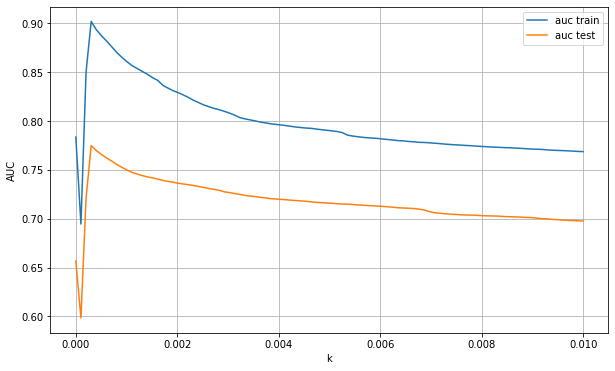

In [52]:
print('TEST: best var_smoothing: {}, max auc: {}'.format(lins[np.argmax(aucs_test_gb)], np.max(aucs_test_gb)))

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(lins, aucs_train_gb, label='auc train')
plt.plot(lins, aucs_test_gb, label='auc test')
plt.xlabel('k')
plt.ylabel('AUC')
plt.legend()

##### tfidf

In [79]:
lins = np.linspace(1000, 1e-02, 100)
aucs_train_tfidf_gb = []
aucs_test_tfidf_gb = []

k = min(800, len(set(' '.join(texts_train).split())))
cv = Counter(' '.join(texts_train).split())#<YOUR CODE>
bow_vocabulary = [el[0] for el in sorted(cv.items(), key=lambda x:x[1], reverse=True)[:k]]#<YOUR CODE>
bow_vocabulary.append('<unknown>')
vect = tfidf_vectorizer(bow_vocabulary)
vect.fit(texts_train)
X_train_tfidf = vect.transform(texts_train)
X_test_tfidf = vect.transform(texts_test)

for v_s in lins:
    clf = GaussianNB(var_smoothing=v_s)
    clf.fit(X_train_tfidf, y_train)
    aucs_train_tfidf_gb.append(roc_auc_score(y_train, clf.predict_proba(X_train_tfidf)[:, 1]))
    aucs_test_tfidf_gb.append(roc_auc_score(y_test, clf.predict_proba(X_test_tfidf)[:, 1]))

TEST: best var_smoothing: 222.2299999999999, max auc: 0.8441558441558441


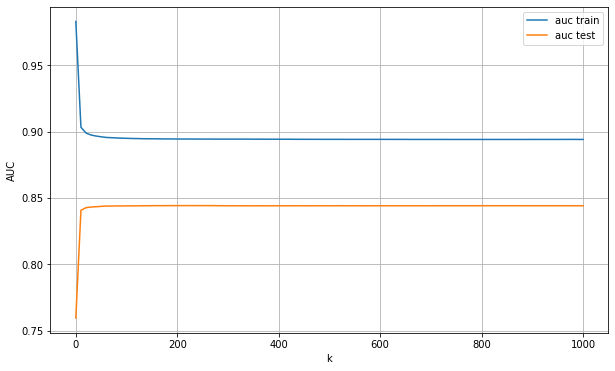

In [80]:
print('TEST: best var_smoothing: {}, max auc: {}'.format(lins[np.argmax(aucs_test_tfidf_gb)],
                                                         np.max(aucs_test_tfidf_gb)))

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(lins, aucs_train_tfidf_gb, label='auc train')
plt.plot(lins, aucs_test_tfidf_gb, label='auc test')
plt.xlabel('k')
plt.ylabel('AUC')
plt.legend()

Shape some thoughts on the results you aquired. Which model has show the best performance? Did changing the learning rate/lr scheduler help?

* Лучший roc auc для модели на BOW признаках: 0.849
* Лучший roc auc для модели на TF-iDF признаках: 0.869
* Наивный байес на BOW признаках(0.775) показал себя хуже, чем на TF-iDF признаках (0.844)
* Изменения learning rate, количества слов в словаре, количества итераций оказывает влияние на качество модели
* lr scheduler я пробовал отключать, качество это не улучшило.
* Результаты получаются неустойчивыми, то есть при перезапуске меняется оптимальное значение параметра.

Далее проведен эксперимент с dropout. В train_model добавлены model.train() и model.eval(). Это немного улучшило качество, если сравнивать с аналогичной моделью без dropout.

In [142]:
def train_model(
    model,
    opt,
    lr_scheduler,
    X_train_torch,
    y_train_torch,
    X_val_torch,
    y_val_torch,
    n_iterations=500,
    batch_size=32,
    warm_start=False,
    show_plots=True,
    eval_every=10
):
    if not warm_start:
        for name, module in model.named_children():
            print('resetting ', name)
            try:
                module.reset_parameters()
            except AttributeError as e:
                print('Cannot reset {} module parameters: {}'.format(name, e))

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []
    for i in range(n_iterations):
        model.train()

        # sample 256 random observations
        ix = np.random.randint(0, len(X_train_torch), batch_size)
        x_batch = X_train_torch[ix]
        y_batch = y_train_torch[ix]

        # predict log-probabilities or logits
        y_predicted = model(x_batch) ### YOUR CODE

        # compute loss, just like before
        ### YOUR CODE
        loss = loss_function(y_predicted, y_batch)

        # compute gradients
        ### YOUR CODE
        loss.backward()

        # Adam step
        ### YOUR CODE
        opt.step()

        # clear gradients
        ### YOUR CODE
        opt.zero_grad()

        local_train_loss_history.append(loss.data.numpy())
        local_train_acc_history.append(
            accuracy_score(
                y_batch.to('cpu').detach().numpy(),
                y_predicted.to('cpu').detach().numpy().argmax(axis=1)
            )
        )

        if i % eval_every == 0:
            model.eval()
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []

            predictions_val = model(X_val_torch)
            val_loss_history.append(loss_function(predictions_val, y_val_torch).to('cpu').detach().item())

            acc_score_val = accuracy_score(y_val_torch.cpu().numpy(), predictions_val.to('cpu').detach().numpy().argmax(axis=1))
            val_acc_history.append(acc_score_val)
            lr_scheduler.step(train_loss_history[-1])

            if show_plots:
                display.clear_output(wait=True)
                plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
    return model

In [143]:
max_k = 10000
k = min(max_k, len(set(' '.join(texts_train).split())))

cv = Counter(' '.join(texts_train).split())#<YOUR CODE>

bow_vocabulary = [el[0] for el in sorted(cv.items(), key=lambda x:x[1], reverse=True)[:k]]#<YOUR CODE>
bow_vocabulary.append('<unknown>')

vect = tfidf_vectorizer(bow_vocabulary)
vect.fit(texts_train)

X_train_tfidf = vect.transform(texts_train)
X_test_tfidf = vect.transform(texts_test)

X_train_tfidf_torch = torch.tensor(X_train_tfidf).float()
X_test_tfidf_torch = torch.tensor(X_test_tfidf).float()

y_train_torch = torch.tensor(y_train)
y_test_torch = torch.tensor(y_test)

inp_shape = X_train_tfidf.shape[1]

model = nn.Sequential()

model.add_module('l1', nn.Linear(inp_shape, 1000))### YOUR CODE HERE
model.add_module('d1', nn.Dropout(p=0.8))
model.add_module('a1', nn.LeakyReLU(1000))

model.add_module('l2', nn.Linear(1000, 300))
model.add_module('a2', nn.LeakyReLU(300))

model.add_module('l3', nn.Linear(300, 2))

loss_function = nn.CrossEntropyLoss()

opt = torch.optim.AdamW(model.parameters(), lr=3e-4)### YOUR CODE HERE
lr_scheduler = ReduceLROnPlateau(opt, patience=5)

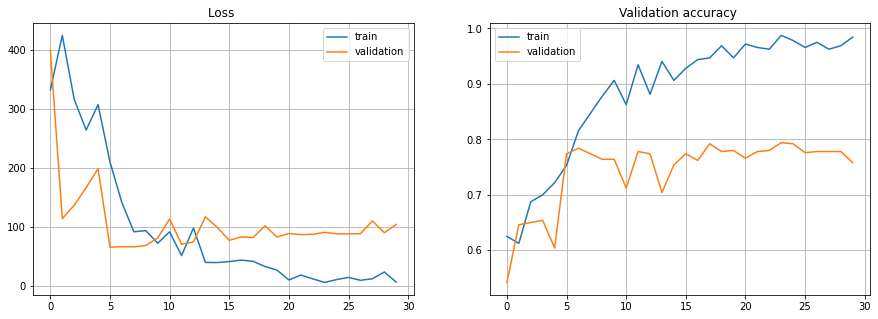

Sequential(
  (l1): Linear(in_features=5723, out_features=1000, bias=True)
  (d1): Dropout(p=0.8, inplace=False)
  (a1): LeakyReLU(negative_slope=1000)
  (l2): Linear(in_features=1000, out_features=300, bias=True)
  (a2): LeakyReLU(negative_slope=300)
  (l3): Linear(in_features=300, out_features=2, bias=True)
)

In [144]:
train_model(model, opt, lr_scheduler, X_train_tfidf_torch, y_train_torch,
            X_test_tfidf_torch, y_test_torch, n_iterations=300)

In [145]:
max_k = 10000
k = min(max_k, len(set(' '.join(texts_train).split())))

cv = Counter(' '.join(texts_train).split())#<YOUR CODE>

bow_vocabulary = [el[0] for el in sorted(cv.items(), key=lambda x:x[1], reverse=True)[:k]]#<YOUR CODE>
bow_vocabulary.append('<unknown>')

vect = tfidf_vectorizer(bow_vocabulary)
vect.fit(texts_train)

X_train_tfidf = vect.transform(texts_train)
X_test_tfidf = vect.transform(texts_test)

X_train_tfidf_torch = torch.tensor(X_train_tfidf).float()
X_test_tfidf_torch = torch.tensor(X_test_tfidf).float()

y_train_torch = torch.tensor(y_train)
y_test_torch = torch.tensor(y_test)

inp_shape = X_train_tfidf.shape[1]

model = nn.Sequential()

model.add_module('l1', nn.Linear(inp_shape, 1000))### YOUR CODE HERE
# model.add_module('d1', nn.Dropout(p=0.8))
model.add_module('a1', nn.LeakyReLU(1000))

model.add_module('l2', nn.Linear(1000, 300))
model.add_module('a2', nn.LeakyReLU(300))

model.add_module('l3', nn.Linear(300, 2))

loss_function = nn.CrossEntropyLoss()

opt = torch.optim.AdamW(model.parameters(), lr=3e-4)### YOUR CODE HERE
lr_scheduler = ReduceLROnPlateau(opt, patience=5)

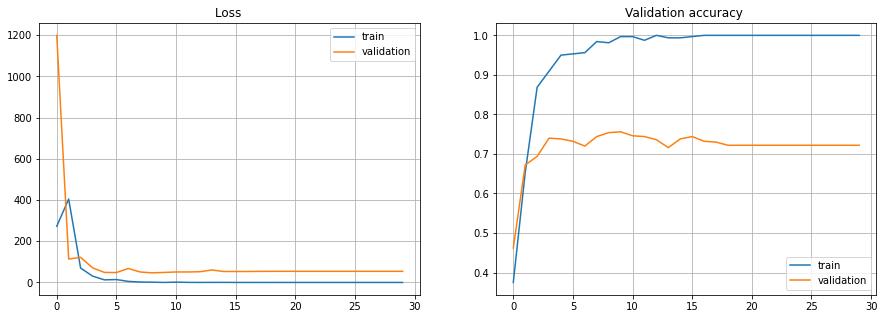

Sequential(
  (l1): Linear(in_features=5723, out_features=1000, bias=True)
  (a1): LeakyReLU(negative_slope=1000)
  (l2): Linear(in_features=1000, out_features=300, bias=True)
  (a2): LeakyReLU(negative_slope=300)
  (l3): Linear(in_features=300, out_features=2, bias=True)
)

In [146]:
train_model(model, opt, lr_scheduler, X_train_tfidf_torch, y_train_torch,
            X_test_tfidf_torch, y_test_torch, n_iterations=300)

### Step 4: Using the external knowledge.

Use the `gensim` word2vec pretrained model to translate words into vectors. Use several models with this new encoding technique. Compare the results, share your thoughts.

In [14]:
import gensim.downloader as api
model = api.load('glove-twitter-25')

In [15]:
def get_phrase_embedding(phrase):
    """
    Convert phrase to a vector by aggregating it's word embeddings. See description above.
    """
    # 1. lowercase phrase
    # 2. tokenize phrase
    # 3. average word vectors for all words in tokenized phrase
    # skip words that are not in model's vocabulary
    # if all words are missing from vocabulary, return zeros
    
    vector = np.zeros([model.vector_size], dtype='float32')
    phrase_tokenized = tokenizer.tokenize(phrase.lower())# YOUR CODE HERE
    phrase_vectors = [model[x] for x in phrase_tokenized if x in model.vocab.keys()]

    if len(phrase_vectors) != 0:
        vector = np.mean(phrase_vectors, axis=0)
    
    return vector

#### GaussianNB

In [108]:
from sklearn.naive_bayes import GaussianNB

lins = np.linspace(2, 0, 100)
aucs_train_gb = []
aucs_test_gb = []

X_train_w2v = np.array([get_phrase_embedding(phrase) for phrase in texts_train])
X_test_w2v = np.array([get_phrase_embedding(phrase) for phrase in texts_test])

for v_s in lins:
    clf = GaussianNB(var_smoothing=v_s)
    clf.fit(X_train_w2v, y_train)
    aucs_train_gb.append(roc_auc_score(y_train, clf.predict_proba(X_train_w2v)[:, 1]))
    aucs_test_gb.append(roc_auc_score(y_test, clf.predict_proba(X_test_w2v)[:, 1]))

TEST: best var_smoothing: 0.7474747474747474, max auc: 0.840470557942677


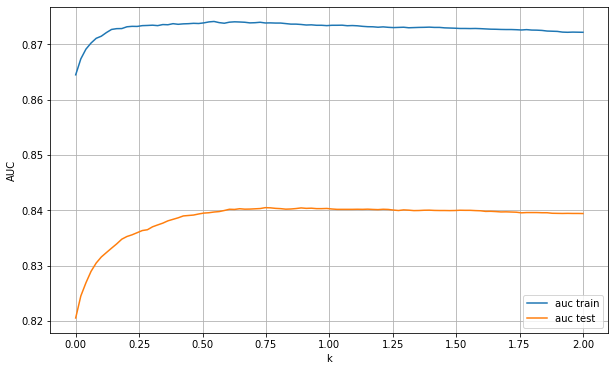

In [109]:
print('TEST: best var_smoothing: {}, max auc: {}'.format(lins[np.argmax(aucs_test_gb)], np.max(aucs_test_gb)))

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(lins, aucs_train_gb, label='auc train')
plt.plot(lins, aucs_test_gb, label='auc test')
plt.xlabel('k')
plt.ylabel('AUC')
plt.legend()

#### LogisticRegression

In [117]:
from sklearn.linear_model import LogisticRegression

lins = np.linspace(0.01, 3, 100)
aucs_train_gb = []
aucs_test_gb = []

X_train_w2v = np.array([get_phrase_embedding(phrase) for phrase in texts_train])
X_test_w2v = np.array([get_phrase_embedding(phrase) for phrase in texts_test])

for c in lins:
    clf = LogisticRegression(C=c)
    clf.fit(X_train_w2v, y_train)
    aucs_train_gb.append(roc_auc_score(y_train, clf.predict_proba(X_train_w2v)[:, 1]))
    aucs_test_gb.append(roc_auc_score(y_test, clf.predict_proba(X_test_w2v)[:, 1]))

TEST: best C: 2.667777777777778, max auc: 0.8828593958705484


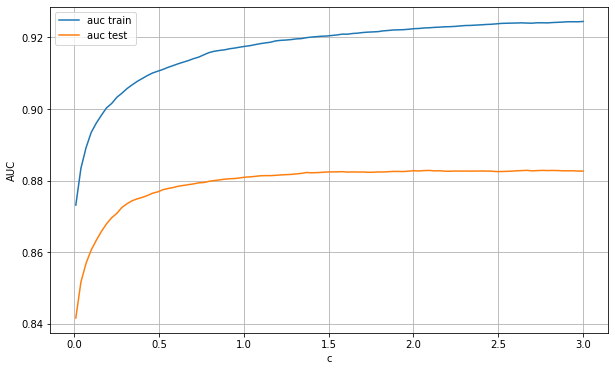

In [118]:
print('TEST: best C: {}, max auc: {}'.format(lins[np.argmax(aucs_test_gb)], np.max(aucs_test_gb)))

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(lins, aucs_train_gb, label='auc train')
plt.plot(lins, aucs_test_gb, label='auc test')
plt.xlabel('c')
plt.ylabel('AUC')
plt.legend()

#### RandomForest

In [115]:
from sklearn.ensemble import RandomForestClassifier

lins = np.linspace(50, 500, 20)
aucs_train_gb = []
aucs_test_gb = []

X_train_w2v = np.array([get_phrase_embedding(phrase) for phrase in texts_train])
X_test_w2v = np.array([get_phrase_embedding(phrase) for phrase in texts_test])

for n_est in lins:
    clf = RandomForestClassifier(n_estimators=int(n_est), random_state=21)
    clf.fit(X_train_w2v, y_train)
    train_probs = clf.predict_proba(X_train_w2v)[:, 1]
    test_probs = clf.predict_proba(X_test_w2v)[:, 1]
    aucs_train_gb.append(roc_auc_score(y_train, train_probs))
    aucs_test_gb.append(roc_auc_score(y_test, test_probs))

TEST: best n_estimators: 357.89473684210526, max auc: 0.8649801252031736


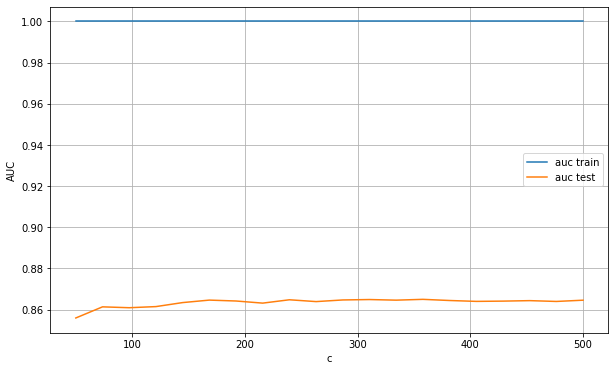

In [116]:
print('TEST: best n_estimators: {}, max auc: {}'.format(lins[np.argmax(aucs_test_gb)], np.max(aucs_test_gb)))

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(lins, aucs_train_gb, label='auc train')
plt.plot(lins, aucs_test_gb, label='auc test')
plt.xlabel('c')
plt.ylabel('AUC')
plt.legend()

#### CatBoost

In [138]:
from catboost import CatBoostClassifier, Pool

lins = ['CrossEntropy', 'Logloss']
aucs_train_gb = []
aucs_test_gb = []

X_train_w2v = np.array([get_phrase_embedding(phrase) for phrase in texts_train])
X_test_w2v = np.array([get_phrase_embedding(phrase) for phrase in texts_test])

for lf in lins:
    clf = CatBoostClassifier(loss_function=lf, verbose=0)
    clf.fit(X_train_w2v, y_train)
    train_probs = clf.predict_proba(X_train_w2v)[:, 1]
    test_probs = clf.predict_proba(X_test_w2v)[:, 1]
    aucs_train_gb.append(roc_auc_score(y_train, train_probs))
    aucs_test_gb.append(roc_auc_score(y_test, test_probs))

TEST: best var_smoothing: Logloss, max auc: 0.8781280677191458


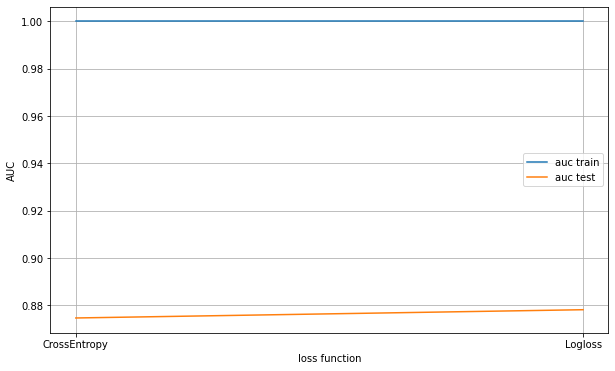

In [139]:
print('TEST: best var_smoothing: {}, max auc: {}'.format(lins[np.argmax(aucs_test_gb)], np.max(aucs_test_gb)))

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(lins, aucs_train_gb, label='auc train')
plt.plot(lins, aucs_test_gb, label='auc test')
plt.xlabel('loss function')
plt.ylabel('AUC')
plt.legend()

* Наивный байес на word2vec показал не тесте 0.84
* Логистическая регрессия 0.882, это был лучший скор, который удалось достичь
* RandomForest 0.865
* Catboost 0.878

В предыдущих пунктах лучший скор был дотсигнут на TF-iDF(0.869), на word2vec удалось достичь большего. Однако, если использовать word2vec большей размерности, то удалось бы достичь большего качества.